In [1]:
from tensorflow.keras.models import model_from_json
import json
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
import time
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, precision_score
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
# CNN model
model_path = '../model/ResNet50_test'

# Spectrograms directory
spectrograms_dir_p = '../dataset_test/STFT/presences/'
spectrograms_dir_a = '../dataset_test/STFT/absences/'

batch_size = 32

# Load CNN model
model = model_from_json(open(model_path+'.json', 'r').read())
model.load_weights(model_path+'.h5')
class_dict = json.load(open(model_path+'_classes.json', 'r'))
class_dict_rev = {(str(v[0])): k for k, v in class_dict.items()}

print(model_path)
print('Loaded model ')

model_input_shape = model.get_layer(index=0).input_shape[1:]
n_classes = model.get_layer(index=-1).output_shape[1:][0]

2022-05-04 19:43:40.270324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:43:40.335959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:43:40.337602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:43:40.341598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

../model/ResNet50_test
Loaded model 


In [3]:
#Read: x_true, x_predict, labels_to_plot

x_true_store = open('x_true.pkl', 'rb') #read binary
x_true = pickle.load(x_true_store)
x_true_store.close()

x_predict_store = open('x_predict.pkl', 'rb') #read binary
x_predict = pickle.load(x_predict_store)
x_predict_store.close()

labels_to_plot_store = open('labels_to_plot.pkl', 'rb') #read binary
labels_to_plot = pickle.load(labels_to_plot_store)
labels_to_plot_store.close()

In [4]:
labels_to_plot[7]='G. magellanica'
labels_to_plot[8]='G. nana (a)'
labels_to_plot[9]='G. nana (b)'
labels_to_plot[13]='P. spiloptera (a)'
labels_to_plot[14]='P. spiloptera (b)'

In [5]:
for c, i in enumerate(labels_to_plot):
    print(c, i)

0 A. thilius
1 A. parulus
2 C. platensis
3 C. parvirostris
4 C. curaeus
5 E. albiceps
6 E. paradoxa
7 G. magellanica
8 G. nana (a)
9 G. nana (b)
10 M. sibilatrix
11 P. sanguinolentus
12 P. melanops
13 P. spiloptera (a)
14 P. spiloptera (b)
15 S. magellanicus
16 S. luteola
17 T. aedon


In [6]:
tax_order = [10, 11, 13, 14, 7, 8, 9, 6, 15, 12, 1, 5, 3, 17, 2, 4, 0, 16] #taxonomy order

In [7]:
colors_sp = [   'orange',
                'darkviolet',
                'crimson',
                'orchid',
                'mediumseagreen',
                'peru',
                'orangered',
                'mediumturquoise',
                'forestgreen',
                'limegreen',
                'cyan',
                'g',
                #'dodgerblue',
                #'coral',
                'khaki',
                'b',
                'indianred',
                'gold',
                'mediumpurple',
                #'darkblue',
                #'tan',
                'sandybrown',
                
            ]

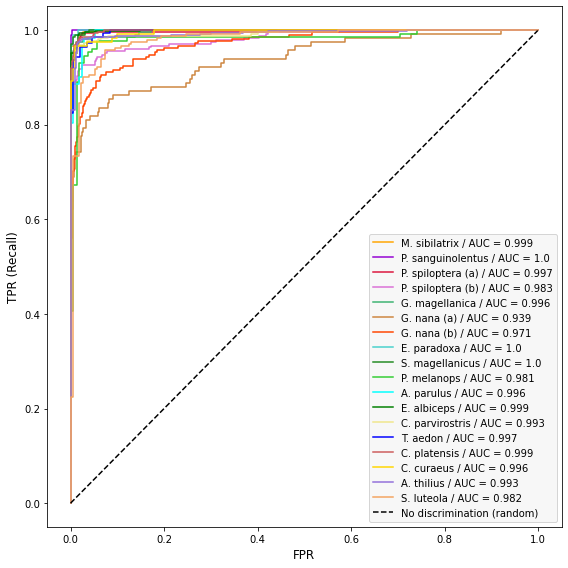

In [8]:
#ROC

plt.figure(figsize=(8,8), facecolor='w')
FPR = []
TPR = []
TH = []
for c, i in enumerate(tax_order):
    fpr_n, tpr_n, th_n = roc_curve(x_true[i], x_predict[i], pos_label=1)
    FPR.append(fpr_n)
    TPR.append(tpr_n)
    TH.append(th_n)
    plt.plot(fpr_n,tpr_n, drawstyle='steps', label=labels_to_plot[i] + 
             ' / AUC = ' + str(round(roc_auc_score(x_true[i], x_predict[i]),3)), color=colors_sp[c])
plt.plot(np.arange(0,1,0.001), np.arange(0,1,0.001), '--', c='k', label='No discrimination (random)')
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR (Recall)', fontsize=12)
plt.legend(fontsize=10, facecolor='whitesmoke')
#plt.title('Receiver Operating Characteristic Curves', fontsize=16)
plt.tight_layout()
#plt.savefig('ROC.png', format='png', dpi=300)
plt.show()

In [9]:
#Optimal thresholds from ROC:

th_opt = []
gmeans_opt = []
for i in tax_order:   
    gmeans = np.sqrt(TPR[i] * (1-FPR[i]))
    ix = np.argmax(gmeans)
    th_opt.append(TH[i][ix])
    gmeans_opt.append(gmeans[ix])
    
TH_gmeans = pd.DataFrame(th_opt)
TH_gmeans.columns=['th_opt']
TH_gmeans['gmeans_opt'] = gmeans_opt
TH_gmeans.insert(value=[class_dict[str(i)] for i in tax_order], column='Specie', loc=0)
TH_gmeans

,Specie,th_opt,gmeans_opt
0,Mareca sibilatrix,0.046195,0.977701
1,Pardirallus sanguinolentus,0.000498,0.987368
2,Porzana spiloptera kiker,0.887201,0.972365
3,Porzana spiloptera pw,0.000142,0.982188
4,Gallinago paraguaiae,0.047799,0.991678
5,Glaucidium nana a,0.325720,0.990634
6,Glaucidium nana b,0.008246,0.960369
7,Eugralla paradoxa,0.098368,0.920182
8,Scytalopus magellanicus,0.290323,0.978428
9,Phleocryptes melanops,0.003400,0.975487


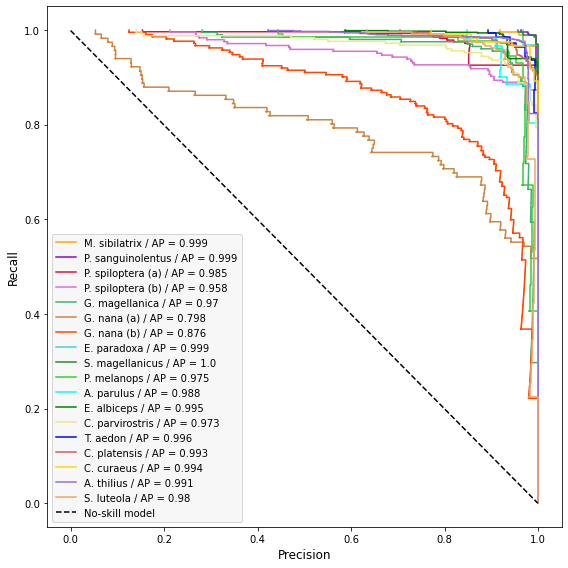

In [10]:
# PRECISION-RECALL

plt.figure(figsize=(8,8), facecolor='w')

PRECISION = []
RECALL = []
TH_pr = []
for c, i in enumerate(tax_order):
    precision_n, recall_n, thre_n = precision_recall_curve(x_true[i], x_predict[i], pos_label=1)
    PRECISION.append(precision_n)
    RECALL.append(recall_n)
    TH_pr.append(thre_n)
    plt.plot(precision_n,recall_n, drawstyle='steps', label=labels_to_plot[i] + 
             ' / AP = ' + str(round(average_precision_score(x_true[i], x_predict[i], pos_label=1),3)),
            color=colors_sp[c])
plt.plot(np.arange(0,1,0.001), np.arange(0,1,0.001)[::-1], '--', c='k', label='No-skill model')
plt.xlabel('Precision', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10, facecolor='whitesmoke')
#plt.title('Precision-Recall Curve', fontsize=16)
plt.tight_layout()
#plt.savefig('Precision-Recall.png', format='png', dpi=300)
plt.show()

In [11]:
#Optimal thresholds from PRECISION-RECALL:

th_opt_ = []
Fscore_opt = []
beta = 1
for i in tax_order:   
    Fscore = (1 + beta**2) * ( (PRECISION[i]*RECALL[i])/(((beta**2)*PRECISION[i])+RECALL[i]) )
    ixx = np.argmax(Fscore)
    th_opt_.append(TH_pr[i][ixx])
    Fscore_opt.append(Fscore[ixx])
    
TH_Fscore = pd.DataFrame(th_opt_)
TH_Fscore.columns=['th_opt_']
TH_Fscore['Fscore_opt'] = Fscore_opt
TH_Fscore.insert(value=[class_dict[str(i)] for i in tax_order], column='Specie', loc=0)
TH_Fscore

,Specie,th_opt_,Fscore_opt
0,Mareca sibilatrix,0.046195,0.944882
1,Pardirallus sanguinolentus,0.147956,0.966460
2,Porzana spiloptera kiker,0.887201,0.968198
3,Porzana spiloptera pw,0.000239,0.960276
4,Gallinago paraguaiae,0.047799,0.983957
5,Glaucidium nana a,0.325720,0.990196
6,Glaucidium nana b,0.012728,0.949020
7,Eugralla paradoxa,0.448105,0.814070
8,Scytalopus magellanicus,0.290323,0.975000
9,Phleocryptes melanops,0.008009,0.933868


In [12]:
beta = 1
Fscore = (1 + beta**2) * ( (precision_n*recall_n)/(((beta**2)*precision_n)+recall_n) )

ixx = np.argmax(Fscore)
print(thre_n[ixx], Fscore[ixx])

0.06723416 0.9426751592356688


In [13]:
optimal_threshold_PrRe = []
for i in range(n_classes):
    clase=i

    precision_n, recall_n, thre_n = precision_recall_curve(x_true[clase], x_predict[clase], pos_label=1)

    optimal_idx = np.argmin(abs(recall_n[0:-1] - precision_n[0:-1]))
    #print(optimal_idx)
    optimal_threshold = thre_n[optimal_idx]
    #print("Threshold value is: ", optimal_threshold)
    #print(precision_n[optimal_idx], recall_n[optimal_idx])
    optimal_threshold_PrRe.append(optimal_threshold)

In [14]:
optimal_threshold_PrRe[17]

0.8730695

In [15]:
labels_to_plot = [labels_to_plot[i] for i in tax_order]

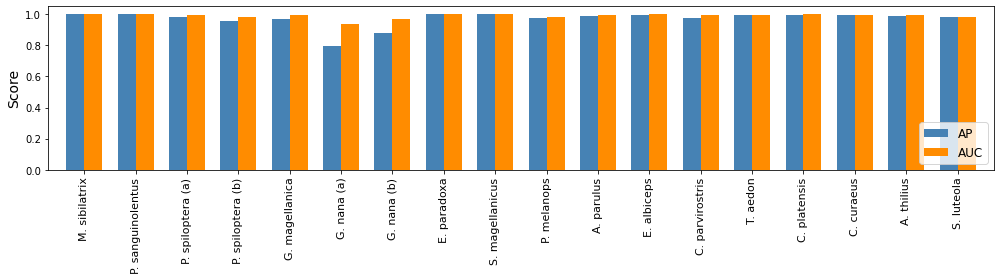

In [16]:
fig = plt.figure(figsize=(14,4), facecolor='w')
ax = fig.add_subplot()
AP_score = []
ROC_AUC_score = []
width=0.35
for i in tax_order:
    AP_score.append(average_precision_score(x_true[i], x_predict[i], pos_label=1))
    ROC_AUC_score.append(roc_auc_score(x_true[i], x_predict[i]))
bar1 = ax.bar(np.arange(n_classes)-width/2, np.around(AP_score,3), width=width, label='AP', color='steelblue')
bar2 = ax.bar(np.arange(n_classes)+width/2, np.around(ROC_AUC_score,3), width=width, label='AUC', color='darkorange')
ax.set_xticks(ticks=np.arange(n_classes))
ax.set_xlim(-0.7,17.7)
ax.set_xticklabels(labels_to_plot, fontsize=11, rotation=90)
ax.set_ylabel('Score', fontsize=14)
#plt.title('Average Precision & ROC-AUC', fontsize=16)
ax.legend(fontsize=12, loc='lower right')
#ax.bar_label(bar1, padding=3, fontsize=6, rotation=60)
#ax.bar_label(bar2, padding=3, fontsize=6, rotation=60)
#ax.set_title('Average Precision & ROC-AUC', fontsize=16)
plt.tight_layout()
plt.savefig('APvsAUC.png', format='png', dpi=300)
plt.show()

In [17]:
mAP = np.mean(AP_score)
print('mean Average Precision (mAP) =',np.around(mAP,4))

mean Average Precision (mAP) = 0.9705


In [ ]:
THRESHOLDS = pd.DataFrame(optimal_threshold_roc)
THRESHOLDS.columns=['ROC']
THRESHOLDS['PrRe'] = optimal_threshold_PrRe
THRESHOLDS.insert(value=[class_dict[str(i)] for i in range(n_classes)], column='Specie', loc=0)

In [ ]:
THRESHOLDS.to_csv('THRESHOLDS.csv')

In [ ]:
THRESHOLDS